# TensorFlow Tutorial #03-B
# Layers API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

It is important to use a builder API when constructing Neural Networks in TensorFlow because it makes it easier to implement and modify the source-code. This also lowers the risk of bugs.

Many of the other tutorials used the TensorFlow builder API called PrettyTensor for easy construction of Neural Networks. But there are several other builder APIs available for TensorFlow. PrettyTensor was used in these tutorials, because at the time in mid-2016, PrettyTensor was the most complete and polished builder API available for TensorFlow. But PrettyTensor is only developed by a single person working at Google and although it has some unique and elegant features, it is possible that it may become deprecated in the future.

This tutorial is about a small builder API that has recently been added to TensorFlow version 1.1. It is simply called *Layers* or the *Layers API* or by its Python name `tf.layers`. This builder API is automatically installed as part of TensorFlow, so you no longer have to install a separate Python package as was needed with PrettyTensor.

This tutorial is very similar to Tutorial #03 on PrettyTensor and shows how to implement the same Convolutional Neural Network using the Layers API. It is recommended that you are familiar with Tutorial #02 on Convolutional Neural Networks.

## Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See Tutorial #02 for a more detailed description of convolution.

![Flowchart](images/02_network_flowchart.png)

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The images are also down-sampled using max-pooling so the image resolution is decreased from 28x28 to 14x14.

These 16 smaller images are then processed in the second convolutional layer. We need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. There are 36 output channels so there are a total of 16 x 36 = 576 filters in the second convolutional layer. The resulting images are also down-sampled using max-pooling to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons (or elements). This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image, that is, which number is depicted in the image.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured as the so-called cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this Notebook.

Note that the computation in TensorFlow is actually done on a batch of images instead of a single image, which makes the computation more efficient. This means the flowchart actually has one more data-dimension when implemented in TensorFlow.

## Imports

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import os
from itertools import islice

This was developed using Python 3.6 and TensorFlow version:

In [85]:
tf.__version__

'1.7.0'

In [86]:
#  Class for Image stuff
#  `take` from :
#https://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

class TF_ImageDataset:
    """  A class for TF Image Datasets:  listImagePaths, listLabels , datasetName = 'generic'  """
    def __init__(self,listImagePaths, listLabels, datasetName):
        if len(listImagePaths) != len(listLabels):
            print("BAD BAD")
        
        self.dictDS = {}
        self.datasetName = datasetName
        self.listImagePaths = listImagePaths
        self.listLabels = listLabels

        for i in range(len(listImagePaths)):
            key = listImagePaths[i]
            val = listLabels[i]
            self.dictDS[key] = val
            
    def summarize(self,topN = 5):
        print("summary :",self.datasetName)
        print("length of listImagePaths: ", len(self.listImagePaths))
        print("length of listLabels: ", len(self.listLabels))
        print(take(topN, self.dictDS.items() ))
            
    def __add__(self, otherClassImgDS, datasetName = "merged"):
        newDict =  {**self.dictDS, **otherClassImgDS.dictDS}
        outKeys = []
        outVals = []
        for key in newDict:
            outKeys.append(key)
            outVals.append(newDict[key])
        return TF_ImageDataset(outKeys, outVals, datasetName)
            
        

## Load Data

Data are loaded in multiple steps.   
- 1 

Requires 2 lists - pathNames to the JPGs, and integer coding of Presence/Absence (1/0)

In [87]:
#  https://stackoverflow.com/questions/37340129/tensorflow-training-on-my-own-image
#  tf1.7
# step 1
pathInputs = "B:\\____MLearning\\03_\\"
pathRC = "B:\\____MLearning\\03_\\rowcrops\\"
pathNon = "B:\\____MLearning\\03_\\non\\"

dirListRC = os.listdir("B:\\____MLearning\\03_\\rowcrops\\")
dirListNon = os.listdir("B:\\____MLearning\\03_\\non\\")
#print(dirListRC)

listRC = []
listRC_labels = []
for items in dirListRC:
    listRC.append(pathRC+items)
    listRC_labels.append(1)

objRC = TF_ImageDataset(listRC, listRC_labels, "RC" )
    
listNon = []
listNon_labels = []
for items in dirListNon:
    listNon.append(pathNon+items)
    listNon_labels.append(0)
#print("listRC & Labels\n", listRC[0:3])
#print(listRC_labels[0:3])


objNon = TF_ImageDataset(listNon, listNon_labels, "Non" )
    
objRC.summarize()
objNon.summarize()

objBoth = objRC + objNon
objBoth.summarize()

summary : RC
length of listImagePaths:  2006
length of listLabels:  2006
[('B:\\____MLearning\\03_\\rowcrops\\aaajtvjlhod.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aaaogunusqn.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aabwgezsbkj.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aacbnyzpydt.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aackxswazps.jpg', 1)]
summary : Non
length of listImagePaths:  3077
length of listLabels:  3077
[('B:\\____MLearning\\03_\\non\\aaaesadvpab.jpg', 0), ('B:\\____MLearning\\03_\\non\\aaafsbrqzqn.jpg', 0), ('B:\\____MLearning\\03_\\non\\aaaqikcbxcj.jpg', 0), ('B:\\____MLearning\\03_\\non\\aaatomgskzv.jpg', 0), ('B:\\____MLearning\\03_\\non\\aaavnyeqjeq.jpg', 0)]
summary : merged
length of listImagePaths:  5083
length of listLabels:  5083
[('B:\\____MLearning\\03_\\rowcrops\\aaajtvjlhod.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aaaogunusqn.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aabwgezsbkj.jpg', 1), ('B:\\____MLearning\\03_\\rowcrops\\aacbnyzp

In [100]:
# https://cs230-stanford.github.io/tensorflow-input-data.html#building-an-image-data-pipeline

def parse_function(filename, label):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    resized_image = tf.image.resize_images(image, [64, 64])
    return resized_image, label

def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label


In [107]:
# https://stackoverflow.com/questions/37340129/tensorflow-training-on-my-own-image 
# but this is better:
# https://cs230-stanford.github.io/tensorflow-input-data.html#building-an-image-data-pipeline

# using standard names

batchsize = 100
nParCalls = 8

filenames = objBoth.listImagePaths
labels = objBoth.listLabels

dataset = tf.data.Dataset.from_tensor_slices(( filenames , labels ))
dataset = dataset.shuffle(len(filenames))
dataset = dataset.map(parse_function, num_parallel_calls = nParCalls)
dataset = dataset.map(train_preprocess, num_parallel_calls = nParCalls)
dataset = dataset.batch(batchsize)
dataset = dataset.prefetch(1)

In [108]:
# step 2: create a dataset returning slices of `filenames`

print(dataset)

<PrefetchDataset shapes: ((?, 64, 64, 3), (?,)), types: (tf.float32, tf.int32)>


In [109]:
# step 3: parse every image in the dataset using `map`
# currently NOT USED
def _parse_function(filename, label):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

In [45]:
# step 4: create iterator and final input tensor
iterator = dataset.make_one_shot_iterator()
images, labels = iterator.get_next()

def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

dataset = train_input_fn(images, labels, 100)

TypeError: Tensor objects are not iterable when eager execution is not enabled. To iterate over this tensor use tf.map_fn.

In [23]:
#from tensorflow.examples.tutorials.mnist import input_data
#data = input_data.read_data_sets('data/MNIST/', one_hot=True)

The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [24]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:


AttributeError: 'BatchDataset' object has no attribute 'train'

The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [6]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

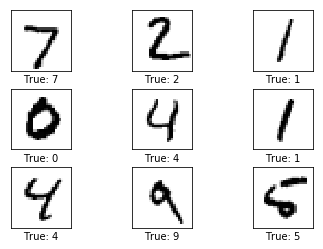

In [8]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional neural network.
* A so-called cost-measure or loss-function that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

## Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [10]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [11]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [12]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


## PrettyTensor Implementation

This section shows the implementation of a Convolutional Neural Network using PrettyTensor taken from Tutorial #03 so it can be compared to the implementation using the Layers API below. This code has been enclosed in an `if False:` block so it does not run here.

The basic idea is to wrap the input tensor `x_image` in a PrettyTensor object which has helper-functions for adding new computational layers so as to create an entire Convolutional Neural Network. This is a fairly simple and elegant syntax.

In [13]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## Layers Implementation

We now implement the same Convolutional Neural Network using the Layers API that is included in TensorFlow version 1.1. This requires more code than PrettyTensor, although a lot of the following are just comments.

We use the `net`-variable to refer to the last layer while building the Neural Network. This makes it easy to add or remove layers in the code if you want to experiment. First we set the `net`-variable to the reshaped input image.

In [14]:
net = x_image

The input image is then input to the first convolutional layer, which has 16 filters each of size 5x5 pixels. The activation-function is the Rectified Linear Unit (ReLU) described in more detail in Tutorial #02.

In [15]:
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)

One of the advantages of constructing neural networks in this fashion, is that we can now easily pull out a reference to a layer. This was more complicated in PrettyTensor.

Further below we want to plot the output of the first convolutional layer, so we create another variable for holding a reference to that layer.

In [16]:
layer_conv1 = net

We now do the max-pooling on the output of the convolutional layer. This was also described in more detail in Tutorial #02.

In [17]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

We now add the second convolutional layer which has 36 filters each with 5x5 pixels, and a ReLU activation function again.

In [18]:
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

We also want to plot the output of this convolutional layer, so we keep a reference for later use.

In [19]:
layer_conv2 = net

The output of the second convolutional layer is also max-pooled for down-sampling the images.

In [20]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

The tensors that are being output by this max-pooling are 4-rank, as can be seen from this:

In [21]:
net

<tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 7, 7, 36) dtype=float32>

Next we want to add fully-connected layers to the Neural Network, but these require 2-rank tensors as input, so we must first flatten the tensors.

The `tf.layers` API was first located in `tf.contrib.layers` before it was moved into TensorFlow Core. But even though it has taken the TensorFlow developers a year to move these fairly simple functions, they have somehow forgotten to move the even simpler `flatten()` function. So we still need to use the one in `tf.contrib.layers`.

In [22]:
net = tf.contrib.layers.flatten(net)

# This should eventually be replaced by:
# net = tf.layers.flatten(net)

This has now flattened the data to a 2-rank tensor, as can be seen from this:

In [23]:
net

<tf.Tensor 'Flatten/Reshape:0' shape=(?, 1764) dtype=float32>

We can now add fully-connected layers to the neural network. These are called *dense* layers in the Layers API.

In [24]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

We need the neural network to classify the input images into 10 different classes. So the final fully-connected layer has `num_classes=10` output neurons.

In [25]:
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

The output of the final fully-connected layer are sometimes called logits, so we have a convenience variable with that name.

In [26]:
logits = net

We use the softmax function to 'squash' the outputs so they are between zero and one, and so they sum to one.

In [27]:
y_pred = tf.nn.softmax(logits=logits)

This tells us how likely the neural network thinks the input image is of each possible class. The one that has the highest value is considered the most likely so its index is taken to be the class-number.

In [28]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


We have now created the exact same Convolutional Neural Network in a few lines of code that required many complex lines of code in the direct TensorFlow implementation.

The Layers API is perhaps not as elegant as PrettyTensor, but it has some other advantages, e.g. that we can more easily refer to intermediate layers, and it is also easier to construct neural networks with branches and multiple outputs using the Layers API.

### Loss-Function to be Optimized

To make the model better at classifying the input images, we must somehow change the variables of the Convolutional Neural Network.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the model.

TensorFlow has a function for calculating the cross-entropy, which uses the values of the `logits`-layer because it also calculates the softmax internally, so as to to improve numerical stability.

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [30]:
loss = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the Adam optimizer with a learning-rate of 1e-4.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [31]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Classification Accuracy

We need to calculate the classification accuracy so we can report progress to the user.

First we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [32]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [33]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Getting the Weights

Further below, we want to plot the weights of the convolutional layers. In the TensorFlow implementation we had created the variables ourselves so we could just refer to them directly. But when the network is constructed using a builder API such as `tf.layers`, all the variables of the layers are created indirectly by the builder API. We therefore have to retrieve the variables from TensorFlow.

First we need a list of the variable names in the TensorFlow graph:

In [95]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var)

<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 1, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'layer_fc_out/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel/Adam:0' shape=(5, 5, 1, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel/Adam_1:0' shape=(5, 5, 1, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias/Adam:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias/Adam_1:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel/Adam:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel/Adam_1:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'l

Each of the convolutional layers has two variables. For the first convolutional layer they are named `layer_conv1/kernel:0` and `layer_conv1/bias:0`. The `kernel` variables are the ones we want to plot further below.

It is somewhat awkward to get references to these variables, because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [96]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [97]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [98]:
session = tf.Session()

### Initialize variables

The variables for the TensorFlow graph must be initialized before we start optimizing them.

In [99]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to do more optimization iterations.

In [100]:
train_batch_size = 64

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [101]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [1]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [103]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Below is a function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [104]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

The accuracy on the test-set is very low because the variables for the neural network have only been initialized and not optimized at all, so it just classifies the images randomly.

In [105]:
print_test_accuracy()

Accuracy on Test-Set: 0.0% (0 / 10000)


## Performance after 1 optimization iteration

The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [106]:
optimize(num_iterations=1)

InvalidArgumentError: logits and labels must be same size: logits_size=[64,784] labels_size=[64,10]
	 [[Node: SoftmaxCrossEntropyWithLogits_1 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_5, Reshape_6)]]

Caused by op 'SoftmaxCrossEntropyWithLogits_1', defined at:
  File "c:\pf\python36\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\pf\python36\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "c:\pf\python36\Lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "c:\pf\python36\Lib\asyncio\base_events.py", line 1426, in _run_once
    handle._run()
  File "c:\pf\python36\Lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-bf35503af9df>", line 1, in <module>
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1597, in softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 2385, in _softmax_cross_entropy_with_logits
    features=features, labels=labels, name=name)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\dkvandyke\envs\jupyter-tf-cpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): logits and labels must be same size: logits_size=[64,784] labels_size=[64,10]
	 [[Node: SoftmaxCrossEntropyWithLogits_1 = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Reshape_5, Reshape_6)]]


In [47]:
print_test_accuracy()

Accuracy on Test-Set: 14.4% (1443 / 10000)


## Performance after 100 optimization iterations

After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [48]:
%%time
optimize(num_iterations=99) # We already performed 1 iteration above.

Wall time: 2.07 s


Accuracy on Test-Set: 76.8% (7681 / 10000)
Example errors:


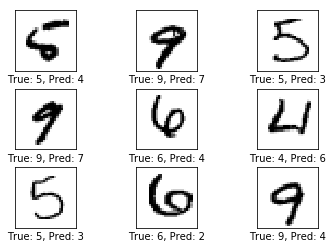

In [49]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [51]:
%%time
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy:  90.6%
Wall time: 18.1 s


Accuracy on Test-Set: 94.9% (9494 / 10000)
Example errors:


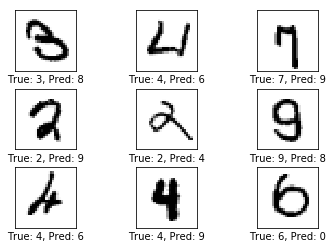

In [52]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

After 10,000 optimization iterations, the model has a classification accuracy on the test-set of about 99%.

In [53]:
%%time
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy:  93.8%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  92.2%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization Iteration:   2701, Training Accuracy:  96.9%
Optimization Iteration:   2801, Training Accuracy:  93.8%
Optimization Iteration:   2901, Training Accuracy:  96.9%
Optimization Iteration:   3001, Training Accuracy:  95.3%
Optimization Iteration:   3101, Training Accuracy:  96.9%
Optimization Iteration:   3201, Training Accuracy:  95.3%
Optimization Iteration:   3301, Training Accuracy:  92.2%
Optimization Iteration:   3401, Training Accuracy:  98.4%
Optimization Iteration:   3501, Training Accuracy:  95.3%
Optimization I

Accuracy on Test-Set: 98.8% (9884 / 10000)
Example errors:


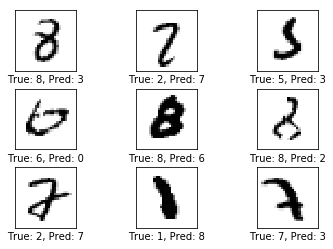

Confusion Matrix:
[[ 975    0    0    0    0    1    2    1    1    0]
 [   0 1127    2    0    0    0    2    2    2    0]
 [   2    0 1024    1    1    0    0    4    0    0]
 [   0    0    0 1006    0    1    0    1    2    0]
 [   0    0    1    0  979    0    1    0    0    1]
 [   2    0    0    7    0  879    3    0    1    0]
 [   5    2    0    1    1    3  946    0    0    0]
 [   0    1    4    2    0    0    0 1018    1    2]
 [   1    0    3   10    1    1    1    2  951    4]
 [   1    3    0    6    8    4    0    6    2  979]]


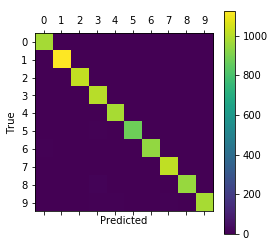

In [52]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of Weights and Layers

### Helper-function for plotting convolutional weights

In [54]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [60]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images

Helper-function for plotting an image.

In [61]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Plot an image from the test-set which will be used as an example below.

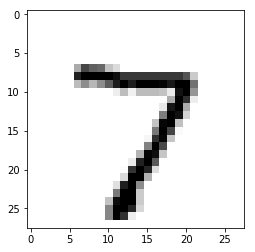

In [62]:
image1 = data.test.images[0]
plot_image(image1)

Plot another example image from the test-set.

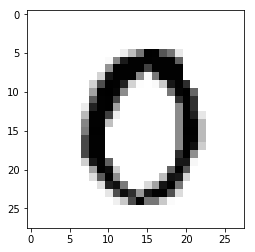

In [63]:
image2 = data.test.images[13]
plot_image(image2)

### Convolution Layer 1

Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

In [64]:
plot_conv_weights(weights=weights_conv1)

NameError: name 'weights_conv1' is not defined

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer.

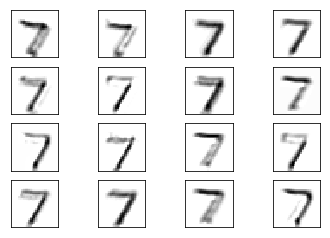

In [59]:
plot_conv_layer(layer=layer_conv1, image=image1)

The following images are the results of applying the convolutional filters to the second image.

AttributeError: 'AxesSubplot' object has no attribute 'flat'

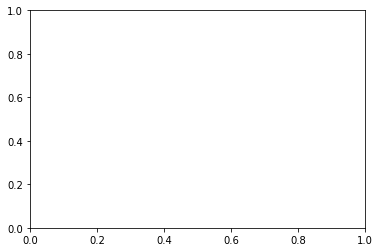

In [65]:
plot_conv_layer(layer=layer_conv1, image=image2)

### Convolution Layer 2

Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

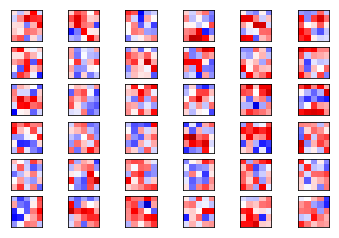

In [61]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel. 

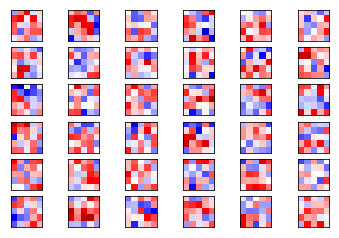

In [62]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled to 14 x 14 pixels which is half the resolution of the original input images, because the first convolutional layer was followed by a max-pooling layer with stride 2. Max-pooling is also done after the second convolutional layer, but we retrieve these images before that has been applied.

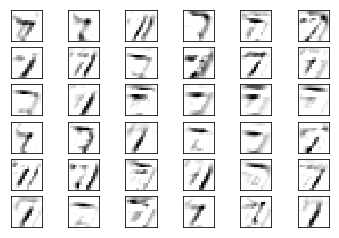

In [63]:
plot_conv_layer(layer=layer_conv2, image=image1)

And these are the results of applying the filter-weights to the second image.

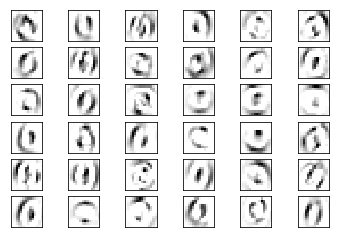

In [64]:
plot_conv_layer(layer=layer_conv2, image=image2)

### Close TensorFlow Session

We are now done using TensorFlow, so we close the session to release its resources.

In [65]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Conclusion

This tutorial showed how to use the so-called *Layers API* for easily building Convolutional Neural Networks in TensorFlow. The syntax is different and more verbose than that of PrettyTensor. Both builder API's have advantages and disadvantages, but since PrettyTensor is only developed by one person and the Layers API is now an official part of TensorFlow Core, it is possible that PrettyTensor will become deprecated in the future. If this happens, we might hope that some of its unique and elegant features will become integrated into TensorFlow Core as well.

I have been trying to get a clear answer from the TensorFlow developers for almost a year, on which of their APIs will be the main builder API for TensorFlow. They still seem to be undecided and very slow to implement it.

## Exercises

These are a few suggestions for exercises that may help improve your skills with TensorFlow. It is important to get hands-on experience with TensorFlow in order to learn how to use it properly.

You may want to backup this Notebook before making any changes.

* Change the activation function to sigmoid for some of the layers.
* Can you find a simple way of changing the activation function for all the layers?
* Add a dropout-layer after the fully-connected layer. If you want a different probability during training and testing then you will need a placeholder variable and set it in the feed-dict.
* Plot the output of the max-pooling layers instead of the conv-layers.
* Replace the 2x2 max-pooling layers with stride=2 in the convolutional layers. Is there a difference in classification accuracy? What if you optimize it again and again? The difference is random, so how would you measure if there really is a difference? What are the pros and cons of using max-pooling vs. stride in the conv-layer?
* Change the parameters for the layers, e.g. the kernel, depth, size, etc. What is the difference in time usage and classification accuracy?
* Add and remove some convolutional and fully-connected layers.
* What is the simplest network you can design that still performs well?
* Retrieve the bias-values for the convolutional layers and print them. See `get_weights_variable()` for inspiration.
* Remake the program yourself without looking too much at this source-code.
* Explain to a friend how the program works.

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.